Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - loss: 0.1264 
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 0.0887
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.0748
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.0697
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 0.0704
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.0726
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.0706
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 0.0683
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 0.0669
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 0.0679
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 0.0702
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 0.0659
Epoch 13/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 0.0728
Epoch 14/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 0.0717
Epoch 15/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


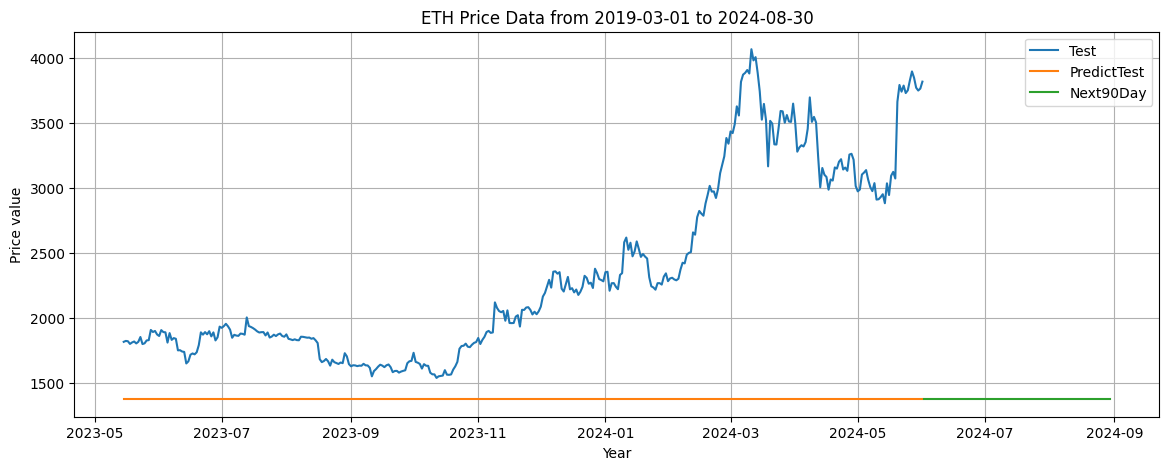

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from keras.models import Model
from keras.layers import Input, Dense, LayerNormalization, Dropout, TimeDistributed, Activation
from keras.layers import MultiHeadAttention
from keras.optimizers import Adam

# Load data
df = pd.read_csv(r'/Users/khoanguyen/Downloads/Ethereum_Historical_Data.csv', on_bad_lines='skip', low_memory=False)
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
# Select the Close column as the dependent variable
df_Price = df[['Price']]
df_Price = df_Price.reset_index(drop=True)
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Price))

# Split data into train and test sets
train_size = int(0.8 * len(data_scaled))
test_size = int(0.2 * len(data_scaled))
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Preparing training data
x_train = np.arange(train_size).reshape(-1, 1)
y_train = train_data.reshape(-1)
# Reshape data for Pyraformer input [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))

# Define the Pyraformer model
def pyraformer_model(input_shape):
    inputs = Input(shape=input_shape)

    # Multi-head attention layer
    attn_output = MultiHeadAttention(num_heads=2, key_dim=2)(inputs, inputs)
    attn_output = Dropout(0.1)(attn_output)
    attn_output = LayerNormalization(epsilon=1e-6)(attn_output + inputs)

    # Feed-forward network
    ffn_output = Dense(4, activation='relu')(attn_output)
    ffn_output = Dense(input_shape[-1])(ffn_output)
    ffn_output = Dropout(0.1)(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output + attn_output)

    outputs = Dense(1)(ffn_output)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build the model
model = pyraformer_model((x_train.shape[1], x_train.shape[2]))
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=32)

# Preparing testing data
x_test = np.array(range(train_size, len(data_scaled))).reshape(-1, 1)
y_test = np.array(test_data).reshape(-1)
# Reshape data for Pyraformer input [samples, time steps, features]
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

# Predict the closing prices for the test data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Evaluate the accuracy of the test data
y_test = scaler.inverse_transform(np.array([y_test]).reshape(-1, 1))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)


print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSE on Test dataset: {test_mse}")


# The process of creating index to predict the next 90 days
last_index = df_Price.index[-1]
# Create an array of 90 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index + 1, last_index + 91)).reshape(-1, 1)
# Reshape data for Pyraformer input [samples, time steps, features]
x_next_90_days = np.reshape(x_next_90_days, (x_next_90_days.shape[0], 1, x_next_90_days.shape[1]))

# Predict the closing prices for the next 90 days
y_next_90_days = model.predict(x_next_90_days)
y_next_90_days = scaler.inverse_transform(y_next_90_days.reshape(-1, 1))

# Print the predicted closing prices for the next 90 days
print('Predicted ETH prices for the next 90 days:')
print(y_next_90_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]
# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 90 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size:], y_test)
plt.plot(df.index[train_size:], y_pred)
plt.plot(index_next_90_days, y_next_90_days)
plt.legend(['Test', 'PredictTest', 'Next90Day'])
plt.grid()
plt.title(f"ETH Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_90_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()
